In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Original Training Data Distribution:
Training_Program
0    26
2    24
3    22
1    21
4    18
5    18
6    12
7    11
Name: count, dtype: int64

Training Data Distribution After SMOTE:
Training_Program
7    26
1    26
2    26
4    26
6    26
3    26
5    26
0    26
Name: count, dtype: int64
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best Parameters: {'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'class_weight': None, 'C': 1000}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.67      0.80      0.73         5
           2       0.67      0.67      0.67         6
           3       0.60      0.50      0.55         6
           4       0.33      0.20      0.25         5
           5       0.57      1.00      0.73         4
           6       0.75      1.00      0.86         3
           7       1.00      0.67      0.80         3

    accuracy                         

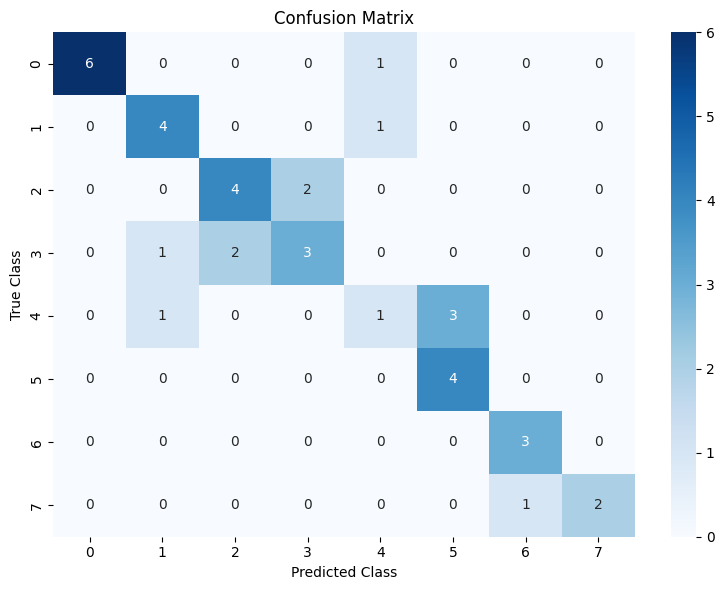

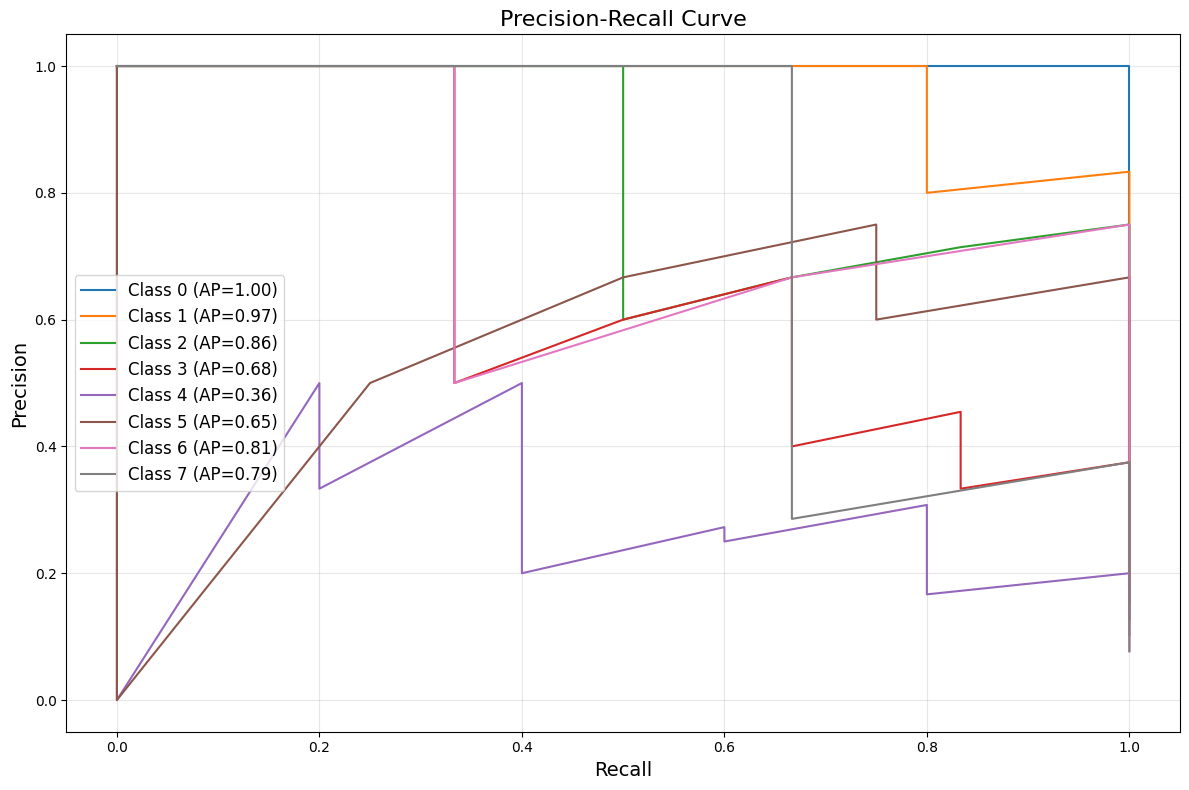


Overall PR AUC (Macro Average): 0.76
Permutation Importance for SVC:
               Feature  Importance
19  chronic_conditions    0.252991
5    sports_experience    0.197436
6             body_fat    0.077778
3                  age    0.069231
7                goals    0.063248
16               hip_c    0.052991
15             waist_c    0.044444
4        resting_pulse    0.040171
10      W/Height_Ratio    0.023932
0               gender    0.013675
8                  BMI    0.009402
1               height    0.005983
14          left_arm_c   -0.002564
13         right_arm_c   -0.005983
2               weight   -0.010256
11          shoulder_c   -0.016239
12             chest_c   -0.016239
17         upper_leg_c   -0.019658
18           lower_leg   -0.029060
9          W/Hip_Ratio   -0.064103


C:\Users\licop\AppData\Local\Temp\ipykernel_8624\867015800.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=svm_importances, x='Importance', y='Feature', palette='viridis')


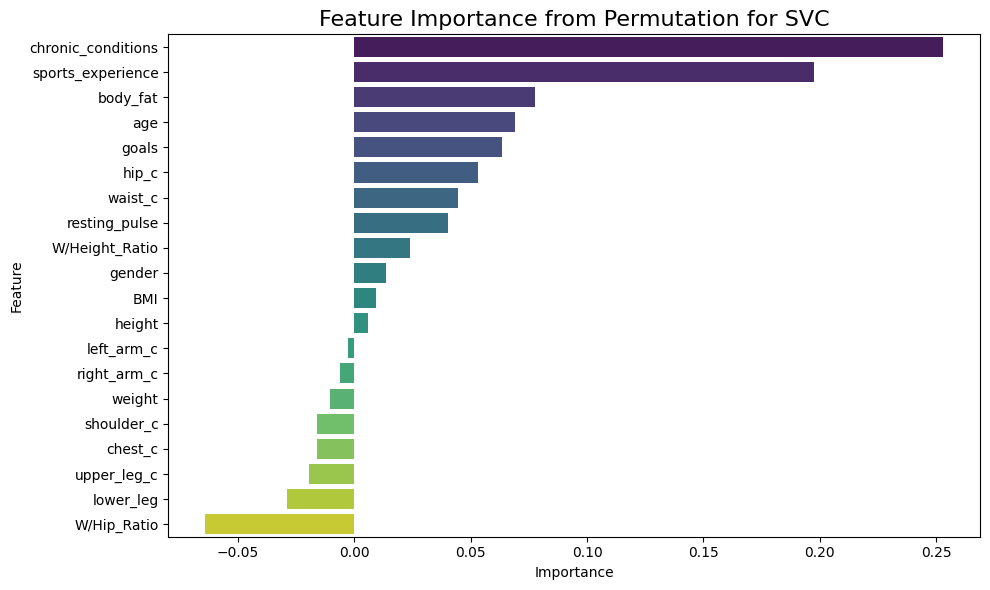

In [9]:
# Define the seed for reproducibility
seed = 12 

# Load the dataset
VT = pd.read_csv("data/processed_VT_Data.csv")
pd.set_option('display.max_columns', None)

# Separate features and target variable
X = VT.drop(columns=["Training_Program", "surgeries"])
y = VT["Training_Program"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Generate synthetic data with SMOTE
smote = SMOTE(random_state=seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original Training Data Distribution:")
print(pd.Series(y_train).value_counts())
print("\nTraining Data Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Define the SVM model
svm_model = SVC(probability=True, random_state=seed)

# Define hyperparameters for optimization
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [0.001, 0.01, 'scale', 'auto'],
    'degree': [2, 3, 4, 5, 6],
    'class_weight': [None, 'balanced']
}

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=4,
    random_state=seed,
    verbose=1,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
random_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and model performance
print("Best Parameters:", random_search.best_params_)

# Evaluate the best model
best_svm = random_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_svm.classes_, yticklabels=best_svm.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# Binarize the output (One-vs-Rest approach for multi-class Precision-Recall)
y_test_binarized = label_binarize(y_test, classes=best_svm.classes_)
y_prob = best_svm.predict_proba(X_test)

# Initialize plot for PR Curve
plt.figure(figsize=(12, 8))

# Loop through each class
for i, class_label in enumerate(best_svm.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_prob[:, i])
    auc_score = average_precision_score(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f'Class {class_label} (AP={auc_score:.2f})')

# Plot settings
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Display overall Average Precision Score (macro average)
overall_auc = average_precision_score(y_test_binarized, y_prob, average="macro")
print(f"\nOverall PR AUC (Macro Average): {overall_auc:.2f}")

# Calculate Permutation Importance
perm_importance_svm = permutation_importance(best_svm, X_test, y_test, n_repeats=30, random_state=seed)

# Store permutation importance in a DataFrame
svm_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance_svm.importances_mean
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Permutation Importance for SVC:")
print(svm_importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=svm_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Permutation for SVC', fontsize=16)
plt.tight_layout()
plt.show()
